# Environment Preparation

## Imports

In [66]:
import re
import os
import io
import boto3
import pickle
import numpy             as np
import pandas            as pd
import seaborn           as sns
import datetime          as dt
import umap.umap_        as umap

from matplotlib               import pyplot as plt
from tabulate                 import tabulate

from sklearn                  import preprocessing as pp
from sklearn                  import metrics as m
from scipy.cluster            import hierarchy as hc

from sqlalchemy               import create_engine
from sqlalchemy.pool          import NullPool
from dotenv                   import load_dotenv

In [67]:
# AWS S3 parameters (used to load dataset, transformations and umap model from S3)
#keys
AWS_ACCESS_KEY_ID_S3 = os.environ.get('AWS_ACCESS_KEY_ID_S3')
AWS_SECRET_ACCESS_KEY_S3 = os.environ.get('AWS_SECRET_ACCESS_KEY_S3')
#configs
AWS_REGION = "us-east-1"
S3_BUCKET_NAME = "loyals-dataset"
#prepare bucket
s3_resource = boto3.resource("s3", region_name=AWS_REGION)
s3_bucket = s3_resource.Bucket(S3_BUCKET_NAME) 

# Data Collection

In [68]:
##AWS S3 - List buckets
# client = boto3.client("s3", region_name=AWS_REGION)
# response = client.list_buckets()

# print("List of Amazon S3 Buckets:")
# for bucket in response['Buckets']:
#     print(f"-- {bucket['Name']}")

In [69]:
##AWS S3 - List all files of S3_BUCKET_NAME 
# print(f'Amazon S3 objects of bucket "{S3_BUCKET_NAME}" ')
# for obj in s3_bucket.objects.all():
#     print(f'-- {obj.key}')

In [70]:
##AWS S3 - load dataset (Ecommerce.csv)
dataset_raw = s3_bucket.Object('Ecommerce.csv')
df_raw = pd.read_csv(io.BytesIO(dataset_raw.get()['Body'].read()), encoding='iso-8859-1') 

In [71]:
## Local - read local dataset
# path = '/Users/home/repos/pa005_fidelity_program/'
# df_raw = pd.read_csv(path +'data/raw/Ecommerce.csv', encoding='unicode_escape' )#, #encoding='iso-8859-1'

In [72]:
df_raw.sample(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
366743,568791,22560,TRADITIONAL MODELLING CLAY,24,27-Sep-17,1.25,16650.0,United Kingdom,NaN


In [73]:
df_raw = df_raw.drop('Unnamed: 8', axis=1).copy()
df_raw.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
259529,559693,85078,SCANDINAVIAN 3 HEARTS NAPKIN RING,2,9-Jul-17,1.63,NaN,United Kingdom
27303,538528,22781,GUMBALL MAGAZINE RACK,2,11-Dec-16,7.65,15689.0,United Kingdom
117493,546388,82583,HOT BATHS METAL SIGN,12,9-Mar-17,4.96,NaN,United Kingdom


# Data Description

In [74]:
df1 = df_raw.copy()

## Rename Columns

In [75]:
df1.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
464528,576112,22572,ROCKING HORSE GREEN CHRISTMAS,12,12-Nov-17,0.85,14902.0,United Kingdom
361500,568346,23201,JUMBO BAG ALPHABET,1,24-Sep-17,4.13,14096.0,United Kingdom
128929,547367,22779,WOODEN OWLS LIGHT GARLAND,1,20-Mar-17,4.25,15437.0,United Kingdom


In [76]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [77]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

## Feature Description 

In [78]:
# Explain feature meanings
tab_meanings = [['Columns', 'Meaning'],
        ['invoice_no', 'unique identifier of each transaction'],
        ['stock_code', 'item code'],
        ['description', 'item name'],
        ['quantity', 'quantity of each item purchased per transaction'],
        ['invoice_date', 'the day the transaction took place'],
        ['unit_price', 'product price per unit'],
        ['customer_id', 'unique customer identifier'],
        ['country', 'customer\'s country of residence']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='simple'))

Columns       Meaning
------------  -----------------------------------------------
invoice_no    unique identifier of each transaction
stock_code    item code
description   item name
quantity      quantity of each item purchased per transaction
invoice_date  the day the transaction took place
unit_price    product price per unit
customer_id   unique customer identifier
country       customer's country of residence


In [79]:
df1.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
98550,544681,21746,SMALL RED RETROSPOT WINDMILL,2,20-Feb-17,2.46,NaN,United Kingdom
293657,562608,22997,TRAVEL CARD WALLET UNION JACK,24,6-Aug-17,0.42,15502.0,United Kingdom
399096,571270,21619,4 VANILLA BOTANICAL CANDLES,3,14-Oct-17,1.25,12940.0,United Kingdom


## Data Dimensions

In [80]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Check NA

In [82]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [83]:
#separate dataset
df_missing = df1.loc[df1['customer_id'].isna()]
df_not_missing = df1.loc[~df1['customer_id'].isna()]

#create reference
df_invoice = pd.DataFrame(df_missing['invoice_no'].drop_duplicates() )
df_invoice['customer_id'] = np.arange(19000,19000+len(df_invoice),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_invoice, on='invoice_no', how='left')

#coalesce equivalent
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x','customer_id_y'], axis=1 )

In [84]:
#check NA
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Change Types

In [85]:
#correct data types ensure correct calculations using the columns on next sessions

In [86]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [87]:
df1.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
109708,545658,16236,KITTY PENCIL ERASERS,8,2-Mar-17,0.21,United Kingdom,14670.0
383583,570036,22037,ROBOT BIRTHDAY CARD,12,5-Oct-17,0.42,United Kingdom,16358.0
264230,560090,21669,BLUE STRIPE CERAMIC DRAWER KNOB,1,12-Jul-17,3.29,United Kingdom,21213.0


In [88]:
#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [89]:
df1.sample(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
258847,559673,23275,SET OF 3 HANGING OWLS OLLIE BEAK,12,2017-07-09,1.25,United Kingdom,13224
208661,555127,22492,MINI PAINT SET VINTAGE,36,2017-05-29,0.65,United Kingdom,15241
437060,574260,22112,CHOCOLATE HOT WATER BOTTLE,3,2017-11-01,4.95,United Kingdom,13014


In [90]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## Descriptive Statistics

In [91]:
#here we identify state of variables, but take action just on proper sections ahead.
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [92]:
num_attributes.head()

,quantity,unit_price,customer_id
0,6,2.55,17850
1,6,3.39,17850
2,8,2.75,17850
3,6,3.39,17850
4,6,3.39,17850


In [93]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
num_metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
num_metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num_metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### Cathegorical Attributes

In [94]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### invoice_no

In [95]:
# problem: we have invoice_no with letters and numbers
#cat_attributes['invoice_no'].astype( int )  # -> error: ex.'C536379'

# identify number of sales with characters on invoice_no: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2017-12-07,0.83,United Kingdom,14397
541541,C581499,M,Manual,-1,2017-12-07,224.69,United Kingdom,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2017-12-07,10.95,United Kingdom,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2017-12-07,1.25,United Kingdom,17315


In [96]:
#looks like all invoice_no with C, has negative quantity. Lets check:
print( f'Total number of invoices: {len( df_letter_invoices )}')
print( f'Total number of negative quantity: {len( df_letter_invoices[ df_letter_invoices["quantity"] < 0 ] )}') 
#3 of difference, let's ignore them

Total number of invoices: 9291
Total number of negative quantity: 9288


#### stock_code

In [97]:
df1['stock_code']

0         85123A
1          71053
2         84406B
3         84029G
4         84029E
           ...  
541904     22613
541905     22899
541906     23254
541907     23255
541908     22138
Name: stock_code, Length: 541909, dtype: object

In [98]:
# get stock_codes with only letters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
#now we have new stock_codes!

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [99]:
#find samples:
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ) ].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
41761,539957,POST,POSTAGE,6,2016-12-21,18.00,Germany,12585
116893,546306,DOT,DOTCOM POSTAGE,1,2017-03-08,147.03,United Kingdom,19843
112232,C545886,M,Manual,-1,2017-03-05,222.59,United Kingdom,19798
54322,C540937,POST,POSTAGE,-1,2017-01-10,7.06,United Kingdom,14748
252771,559134,POST,POSTAGE,5,2017-07-04,18.00,France,12700
257218,559518,DOT,DOTCOM POSTAGE,1,2017-07-06,92.88,United Kingdom,21179
16109,537643,DOT,DOTCOM POSTAGE,1,2016-12-05,593.15,United Kingdom,19114
81879,543180,POST,POSTAGE,4,2017-02-02,40.00,Switzerland,12410
219273,556089,DOT,DOTCOM POSTAGE,1,2017-06-06,93.75,United Kingdom,20847
251050,559052,DOT,DOTCOM POSTAGE,1,2017-07-03,576.18,United Kingdom,21135


# Variable Filtering

In [100]:
df2 = df1.copy()
#df2.to_csv("../data/interim/cycle8/df2_data_description_done.csv")

In [101]:
#remove bad users:
df2 = df2.loc[~df2['customer_id'].isin([16446, 15749, 12346]) ]

##Cat Attr

#2. stock_code - remove useless values:
df2 = df2.loc[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]
#3. description - remove useless feature:
df2 = df2.drop('description', axis=1)
#4. country - remove 2 values:
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

##Num Attr
#2. unit_price - remove <0.03:
df2 = df2.loc[df2['unit_price'] >= 0.04 ]
#1. quantity - separete into 2 datasets:
df2_returns = df2.loc[df2['quantity'] < 0]
df2_purchases = df2.loc[df2['quantity'] > 0] #there is no quantity == 0.

# Feature Engeneering

In [102]:
df3 = df2.copy()
df3_returns = df2_returns.copy()
df3_purchases = df2_purchases.copy()
#df3.to_csv("../data/interim/cycle8/df3_var_filtering_done.csv")
#df3_returns.to_csv("../data/interim/cycle8/df3_returns.csv")
#df3_purchases.to_csv("../data/interim/cycle8/df3_purchases.csv")

In [103]:
#create the referente table with uniques customer_id (and reset index) 
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True).copy()

In [104]:
df_ref

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100
...,...
5779,22706
5780,22707
5781,22708
5782,22709


## Gross Revenue

In [105]:
# Gross Revenue: (quantity * price of each purchase)
    #here, we just want to consider gross revenue from sales, not discounting returns, so lets use df3_purchases
df3_purchases['gross_revenue'] = df3_purchases['quantity'] * df3_purchases['unit_price']
df_monetary = df3_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

## Recency

In [106]:
# Recency: number of days since last purchase
    #here, we want to know the last day this customer bought. If he returned, we don't want to count that day as last purchase, so let's consider just df3_purchases
df_recency = df3_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

## Invoice Quantity

In [107]:
#quantity of invoices per customer
    #consider just purchases, not returns
df_invoice = df3_purchases[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':"qtt_invoices"})
df_ref = pd.merge( df_ref, df_invoice, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtt_invoices     91
dtype: int64

## Unique Products

In [108]:
#quantity of distinct products per customer
    #consider just purchases, not returns
df_invoice = df3_purchases[['customer_id','stock_code']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'stock_code':"unique_products"})
df_ref = pd.merge( df_ref, df_invoice, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qtt_invoices       91
unique_products    91
dtype: int64

## Unique Items

In [109]:
#quantity of items purchased per customer
    #consider just purchases, not returns
df_prod_quantity = df3_purchases[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns ={'quantity':'unique_items'})
df_ref = pd.merge( df_ref, df_prod_quantity, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qtt_invoices       91
unique_products    91
unique_items       91
dtype: int64

## Daily Purchase Rate

In [110]:
# purchase rate per day during the period
#per customer and invoice, get min and max invoice date, total days between min and max, and quantity of invoices
df_aux = ( df3_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
            .groupby( 'customer_id')
            #new column name ('apply on this columns', 'operation')
            .agg( max_invoice_date = ( 'invoice_date', 'max' ), 
                  min_invoice_date = ( 'invoice_date', 'min' ),
                  invoice_total_days= ( 'invoice_date', lambda x: ((x.max() - x.min()).days)+1),
                  invoice_count = ( 'invoice_no', 'count' ) ) ).reset_index()

# Frequency: invoice_count / invoice_total_days (if invoice_total_days != 0)
df_aux['daily_purchase_rate'] = df_aux[['invoice_count', 'invoice_total_days']].apply( 
    lambda x: x['invoice_count'] / x['invoice_total_days'] 
         if  x['invoice_total_days'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'daily_purchase_rate']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
qtt_invoices           91
unique_products        91
unique_items           91
daily_purchase_rate    91
dtype: int64

## Returns

In [111]:
#number of products (items) returned per customer
df_returns = df3_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity':'total_prod_returned'} )

#convert to positive, cause we know it's a devolution, no need to be negative anymore:
df_returns['total_prod_returned'] = df_returns['total_prod_returned'] * -1

#bind
df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )

#since df_ref has all customers (purchases + returns), we can say these 4191 with NA in total_prod_returned are from df3_purchases, so let's assign zero to them:
df_ref.loc[df_ref['total_prod_returned'].isna(), 'total_prod_returned'] = 0

df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
qtt_invoices           91
unique_products        91
unique_items           91
daily_purchase_rate    91
total_prod_returned     0
dtype: int64

# Data Preparation

In [112]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtt_invoices,unique_products,unique_items,daily_purchase_rate,total_prod_returned
0,17850,5391.21,372.0,34.0,21.0,1733.0,17.000000,40.0
1,13047,3232.59,56.0,9.0,105.0,1390.0,0.028302,35.0
2,12583,6705.38,2.0,15.0,114.0,5028.0,0.040323,50.0
3,13748,948.25,95.0,5.0,24.0,439.0,0.017921,0.0
4,15100,876.00,333.0,3.0,1.0,80.0,0.073171,22.0


In [113]:
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
qtt_invoices           91
unique_products        91
unique_items           91
daily_purchase_rate    91
total_prod_returned     0
dtype: int64

In [114]:
df_ref = df_ref.dropna() #was at EDA
df5 = df_ref.copy() #because EDA Uni and Biv were deleted
df5

,customer_id,gross_revenue,recency_days,qtt_invoices,unique_products,unique_items,daily_purchase_rate,total_prod_returned
0,17850,5391.21,372.0,34.0,21.0,1733.0,17.000000,40.0
1,13047,3232.59,56.0,9.0,105.0,1390.0,0.028302,35.0
2,12583,6705.38,2.0,15.0,114.0,5028.0,0.040323,50.0
3,13748,948.25,95.0,5.0,24.0,439.0,0.017921,0.0
4,15100,876.00,333.0,3.0,1.0,80.0,0.073171,22.0
...,...,...,...,...,...,...,...,...
5779,22706,5699.00,1.0,1.0,634.0,1747.0,1.000000,0.0
5780,22707,6756.06,0.0,1.0,730.0,2010.0,1.000000,0.0
5781,22708,3217.20,0.0,1.0,56.0,654.0,1.000000,0.0
5782,22709,3950.72,0.0,1.0,217.0,731.0,1.000000,0.0


In [115]:
##Load transformations

##sample to run file locally without papermill
#gr_scaller = pickle.load(open("../features/gross_revenue.pkl", "rb") )

##sample to run file locally with abs path (to make papermill work locally):  #pickle.load(open('/Users/home/repos/pa005_fidelity_program/src/features/recency_days.pkl', 'rb') )

## loads from AWS S3 
#gross_revenue
gr_scaller = pickle.loads(s3_resource.Bucket("loyals-dataset").Object("gross_rev_scaler.pkl").get()['Body'].read())
df5['gross_revenue'] = gr_scaller.transform(df5[['gross_revenue']])

#recency_days
rd_scaller = pickle.loads(s3_resource.Bucket("loyals-dataset").Object("recency_days_scaler.pkl").get()['Body'].read())
df5['recency_days'] = rd_scaller.transform(df5[['recency_days']])    

#unique_products
up_scaller = pickle.loads(s3_resource.Bucket("loyals-dataset").Object("unique_products_scaler.pkl").get()['Body'].read())
df5['unique_products'] = up_scaller.transform(df5[['unique_products']]) 

#daily_purchase_rate
dpr_scaller = pickle.loads(s3_resource.Bucket("loyals-dataset").Object("daily_purchase_rate_scaler.pkl").get()['Body'].read())
df5['daily_purchase_rate'] = dpr_scaller.transform(df5[['daily_purchase_rate']])

#total_prod_returned
tpr_scaller = pickle.loads(s3_resource.Bucket("loyals-dataset").Object("total_prod_returned_scaler.pkl").get()['Body'].read())
df5['total_prod_returned']=tpr_scaller.transform(df5[['total_prod_returned']])

In [116]:
#after transformations:
df5.head()

,customer_id,gross_revenue,recency_days,qtt_invoices,unique_products,unique_items,daily_purchase_rate,total_prod_returned
0,17850,0.019312,0.997319,34.0,0.011204,1733.0,1.000000,0.004998
1,13047,0.011579,0.150134,9.0,0.058263,1390.0,0.001345,0.004373
2,12583,0.024020,0.005362,15.0,0.063305,5028.0,0.002052,0.006247
3,13748,0.003396,0.254692,5.0,0.012885,439.0,0.000734,0.000000
4,15100,0.003137,0.892761,3.0,0.000000,80.0,0.003985,0.002749


# Feature Selection

In [117]:
df6 = df5.copy()
#df6.to_csv("../data/interim/cycle8/df6_data_prep_done.csv")

In [118]:
#select features for variable space

#drop customer_id
X = df6.drop('customer_id', axis=1).copy()
X.head()

,gross_revenue,recency_days,qtt_invoices,unique_products,unique_items,daily_purchase_rate,total_prod_returned
0,0.019312,0.997319,34.0,0.011204,1733.0,1.000000,0.004998
1,0.011579,0.150134,9.0,0.058263,1390.0,0.001345,0.004373
2,0.024020,0.005362,15.0,0.063305,5028.0,0.002052,0.006247
3,0.003396,0.254692,5.0,0.012885,439.0,0.000734,0.000000
4,0.003137,0.892761,3.0,0.000000,80.0,0.003985,0.002749


In [119]:
#select features
selected_features = ['gross_revenue','recency_days','unique_products','daily_purchase_rate','total_prod_returned'] #5

X = X[selected_features].copy()
X.head()

,gross_revenue,recency_days,unique_products,daily_purchase_rate,total_prod_returned
0,0.019312,0.997319,0.011204,1.000000,0.004998
1,0.011579,0.150134,0.058263,0.001345,0.004373
2,0.024020,0.005362,0.063305,0.002052,0.006247
3,0.003396,0.254692,0.012885,0.000734,0.000000
4,0.003137,0.892761,0.000000,0.003985,0.002749


# EDA - Data Space Study

In [120]:
#as soon as data on original space is not organized, let's look for a better data space with embedding
X.head()

,gross_revenue,recency_days,unique_products,daily_purchase_rate,total_prod_returned
0,0.019312,0.997319,0.011204,1.000000,0.004998
1,0.011579,0.150134,0.058263,0.001345,0.004373
2,0.024020,0.005362,0.063305,0.002052,0.006247
3,0.003396,0.254692,0.012885,0.000734,0.000000
4,0.003137,0.892761,0.000000,0.003985,0.002749


In [121]:
#keep just Umap embedding space (the best)

## UMAP

In [122]:
#UMAP basically takes a dataset in a very high dimension and returns a new dataset with the same number of samples in a space of much lower dimension than the original dimension.
#UMAP is good for a lot of data because it's faster, but it's not as verbose in visualization.

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

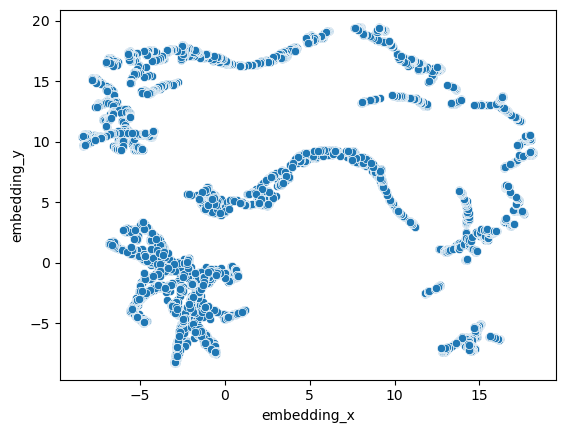

In [123]:
#reducer = umap.UMAP( random_state=42 )

## local load reducer
#reducer = pickle.load(open('/Users/home/repos/pa005_fidelity_program/src/features/umap_model.pkl','rb'))

##load from S3 umap_reducer.pkl
umap_reducer = pickle.loads(s3_resource.Bucket("loyals-dataset").Object("umap_reducer.pkl").get()['Body'].read())

#transform
embedding = umap_reducer.transform( X ) #now just transform

df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

#plot
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_umap )

In [124]:
#evaluation, passing df_umap as dataframe

#set number of clusters
clusters_em = np.arange(2,13,1)
clusters_em

#let's use scipy instead of sklearn, being a simpler implementation.
hc_list_em = []
for k in clusters_em:
    #model definition and training
    hc_model_em = hc.linkage(df_umap, 'ward')

    #model predict
    hc_labels_em = hc.fcluster(hc_model_em, k, criterion='maxclust')#to cut dendrogram

    #model perfomance (SS)
    hc_ss_em = m.silhouette_score(df_umap, hc_labels_em, metric='euclidean')
    hc_list_em.append(hc_ss_em) 

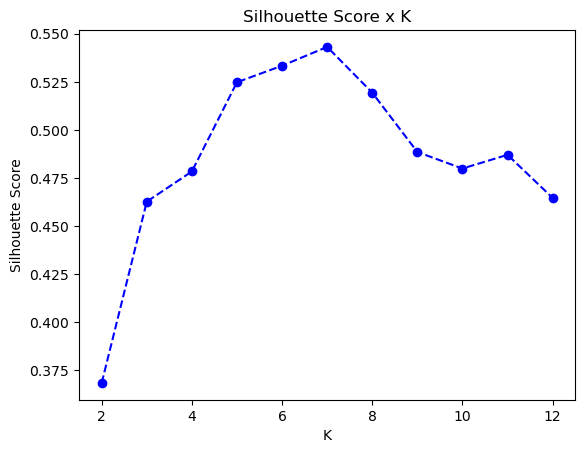

In [125]:
#Silhouette Score (with tree-based embedding from not scaled dataset)
plt.plot(clusters_em, hc_list_em, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

# Model Training

In [126]:
#let's keep using Umap embedding space, where on HC with 8k, we've got an SS of 0.55 
#8Ks is also a good number of cluster for business team handle actions from them
X = df_umap
X

,embedding_x,embedding_y
0,15.686619,-6.099525
1,-0.614432,4.606266
2,-1.989648,-3.996645
3,3.698180,7.299434
4,11.212939,2.988281
...,...,...
5688,0.730741,-1.022232
5689,0.749878,-1.065601
5690,-7.323727,10.308653
5691,-5.586637,12.065847


In [127]:
#8 clusters, as defined
k = 8

#let's use scipy instead of sklearn, being a simpler implementation.
#model definition and training
hc_model = hc.linkage(X, 'ward')

#model predict
hc_labels = hc.fcluster(hc_model, k, criterion='maxclust')#to cut dendrogram

#model perfomance (SS)
hc_ss = m.silhouette_score(X, hc_labels, metric='euclidean') 
print(f'SS Value for {k} clusters: {hc_ss}')

SS Value for 8 clusters: 0.5193468332290649


# Cluster Analysis

## Cluster Profile

In [130]:
df_ref

,customer_id,gross_revenue,recency_days,qtt_invoices,unique_products,unique_items,daily_purchase_rate,total_prod_returned
0,17850,5391.21,372.0,34.0,21.0,1733.0,17.000000,40.0
1,13047,3232.59,56.0,9.0,105.0,1390.0,0.028302,35.0
2,12583,6705.38,2.0,15.0,114.0,5028.0,0.040323,50.0
3,13748,948.25,95.0,5.0,24.0,439.0,0.017921,0.0
4,15100,876.00,333.0,3.0,1.0,80.0,0.073171,22.0
...,...,...,...,...,...,...,...,...
5779,22706,5699.00,1.0,1.0,634.0,1747.0,1.000000,0.0
5780,22707,6756.06,0.0,1.0,730.0,2010.0,1.000000,0.0
5781,22708,3217.20,0.0,1.0,56.0,654.0,1.000000,0.0
5782,22709,3950.72,0.0,1.0,217.0,731.0,1.000000,0.0


In [131]:
df9p = df_ref.copy() #df_ref contains original values (not reescaled), to use in cluster profile
ids_and_vars_selected = ['customer_id','gross_revenue','recency_days','unique_products','daily_purchase_rate','total_prod_returned']
df9p = df9p[ids_and_vars_selected]
df9p['cluster'] = hc_labels

#change dtypes
df9p['recency_days'] = df9p['recency_days'].astype(int)
df9p['unique_products'] = df9p['unique_products'].astype(int)
df9p['total_prod_returned'] = df9p['total_prod_returned'].astype(int)

#record timestamp of training
df9p['last_training'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df9p

,customer_id,gross_revenue,recency_days,unique_products,daily_purchase_rate,total_prod_returned,cluster,last_training
0,17850,5391.21,372,21,17.000000,40,1,2022-09-03 14:41:36
1,13047,3232.59,56,105,0.028302,35,3,2022-09-03 14:41:36
2,12583,6705.38,2,114,0.040323,50,8,2022-09-03 14:41:36
3,13748,948.25,95,24,0.017921,0,3,2022-09-03 14:41:36
4,15100,876.00,333,1,0.073171,22,4,2022-09-03 14:41:36
...,...,...,...,...,...,...,...,...
5779,22706,5699.00,1,634,1.000000,0,8,2022-09-03 14:41:36
5780,22707,6756.06,0,730,1.000000,0,8,2022-09-03 14:41:36
5781,22708,3217.20,0,56,1.000000,0,7,2022-09-03 14:41:36
5782,22709,3950.72,0,217,1.000000,0,7,2022-09-03 14:41:36


In [132]:
#building df_cluster

# Number of customer
df_cluster = df9p[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id'] / df_cluster['customer_id'].sum()*100

# Avg gross revenue
df_avg_gross_revenue = df9p[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9p[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg unique products
df_avg_unique_products = df9p[['unique_products','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_unique_products, how='inner', on='cluster')

# Avg daily purchase rate
df_avg_daily_purchase_rate = df9p[['daily_purchase_rate','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_daily_purchase_rate, how='inner', on='cluster')

# Avg total products returned
df_avg_total_prod_returned = df9p[['total_prod_returned','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_total_prod_returned, how='inner', on='cluster')

# cluster profiles
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,unique_products,daily_purchase_rate,total_prod_returned
7,8,1786,31.371860,3861.640554,17.201568,112.159015,0.061500,42.648936
2,3,509,8.940804,1448.219843,68.840864,60.106090,0.027804,12.388998
1,2,459,8.062533,947.313617,307.518519,93.324619,1.004357,1.494553
3,4,495,8.694888,942.218323,177.333333,42.290909,0.041601,12.800000
5,6,694,12.190409,691.700706,171.952450,59.041787,1.014470,0.968300
6,7,1083,19.023362,638.647608,51.792244,42.975069,1.027645,2.681440
0,1,254,4.461620,549.360866,362.602362,23.393701,1.056134,2.696850
4,5,413,7.254523,330.407240,249.692494,20.878935,1.029056,2.624697


In [133]:
#df_cluster.to_csv('../data/interim/cycle8/df_cluster_kmeans_8k.csv')

In [134]:
#generate the repport dinamically:
for i in range(len(df_cluster['customer_id'])):
    print(f""" Cluster {df_cluster['cluster'][i]}:
    -Number of customers: {df_cluster['customer_id'][i]} ({round(df_cluster['perc_customer'][i])}%)
    -Average revenue: ${round(df_cluster['gross_revenue'][i])}
    -Average recency: by each {round(df_cluster['recency_days'][i])} days ({round(df_cluster['recency_days'][i]/7)} week(s))
    -Average unique products purchased: {round(df_cluster['unique_products'][i])}  
    -Average purchases/month: {round((df_cluster['daily_purchase_rate'][i])*30 ,1)} 
    -Average total products returned: {round(df_cluster['total_prod_returned'][i])} """)

 Cluster 1:
    -Number of customers: 254 (4%)
    -Average revenue: $549
    -Average recency: by each 363 days (52 week(s))
    -Average unique products purchased: 23  
    -Average purchases/month: 31.7 
    -Average total products returned: 3 
 Cluster 2:
    -Number of customers: 459 (8%)
    -Average revenue: $947
    -Average recency: by each 308 days (44 week(s))
    -Average unique products purchased: 93  
    -Average purchases/month: 30.1 
    -Average total products returned: 1 
 Cluster 3:
    -Number of customers: 509 (9%)
    -Average revenue: $1448
    -Average recency: by each 69 days (10 week(s))
    -Average unique products purchased: 60  
    -Average purchases/month: 0.8 
    -Average total products returned: 12 
 Cluster 4:
    -Number of customers: 495 (9%)
    -Average revenue: $942
    -Average recency: by each 177 days (25 week(s))
    -Average unique products purchased: 42  
    -Average purchases/month: 1.2 
    -Average total products returned: 13 
 Cluster

# Deploy

In [135]:
df9p

,customer_id,gross_revenue,recency_days,unique_products,daily_purchase_rate,total_prod_returned,cluster,last_training
0,17850,5391.21,372,21,17.000000,40,1,2022-09-03 14:41:36
1,13047,3232.59,56,105,0.028302,35,3,2022-09-03 14:41:36
2,12583,6705.38,2,114,0.040323,50,8,2022-09-03 14:41:36
3,13748,948.25,95,24,0.017921,0,3,2022-09-03 14:41:36
4,15100,876.00,333,1,0.073171,22,4,2022-09-03 14:41:36
...,...,...,...,...,...,...,...,...
5779,22706,5699.00,1,634,1.000000,0,8,2022-09-03 14:41:36
5780,22707,6756.06,0,730,1.000000,0,8,2022-09-03 14:41:36
5781,22708,3217.20,0,56,1.000000,0,7,2022-09-03 14:41:36
5782,22709,3950.72,0,217,1.000000,0,7,2022-09-03 14:41:36


In [136]:
df9p.dtypes

customer_id              int64
gross_revenue          float64
recency_days             int64
unique_products          int64
daily_purchase_rate    float64
total_prod_returned      int64
cluster                  int32
last_training           object
dtype: object

In [138]:
#create db connection (and db_file if sqlite)

##sqlite
#endpoint = 'sqlite:////Users/home/repos/pa005_fidelity_program/notebooks/loyals_db.sqlite' 

##postgre 
load_dotenv() #load from .env
pg_user = os.environ['pg_user'] 
pg_passwd = os.environ['pg_passwd'] 
pg_host = os.environ['pg_host'] 
pg_port = os.environ['pg_port'] 
#build endpoint
endpoint = f'postgresql://{pg_user}:{pg_passwd}@{pg_host}:{pg_port}'
        
#create connection
db = create_engine(endpoint, poolclass=NullPool)
conn = db.connect()

In [ ]:
# #check if table exists on sqlite
# check_table = """
#     SELECT name FROM sqlite_master WHERE type='table' AND name='loyals';
# """
# df_check = pd.read_sql_query(check_table, conn)

# #create table if does not exist
# if len(df_check) == 0:  #0 = table does not exist, 1 = table exists
#     query_create_table_loyals = """
#     CREATE TABLE loyals (
#         customer_id              INTEGER,
#         gross_revenue            REAL,
#         recency_days             INTEGER,
#         unique_products          INTEGER,
#         daily_purchase_rate      REAL,
#         total_prod_returned      INTEGER,
#         cluster                  INTEGER,
#         last_training            TEXT
#         )"""
#     conn.execute( query_create_table_loyals )
#     print('Table loyals was created!')
# else:
#     print('Table loyals exists!')

In [69]:
#create table
# query_create_table_loyals = """
#     CREATE TABLE loyals (
#         customer_id              INTEGER,
#         gross_revenue            REAL,
#         recency_days             INTEGER,
#         unique_products          INTEGER,
#         daily_purchase_rate      REAL,
#         total_prod_returned      INTEGER,
#         cluster                  INTEGER,
#         last_training            TEXT
#         )"""
# conn.execute( query_create_table_loyals )

In [110]:
#insert data into table loyals using sqlalchemy, appending data
df9p.to_sql('loyals', con=conn, if_exists='append', index=False )#index=False to ignore dataframe index

693

In [139]:
#consult database
query = """
    SELECT * FROM loyals
"""
df = pd.read_sql_query(query, conn)
df

,customer_id,gross_revenue,recency_days,unique_products,daily_purchase_rate,total_prod_returned,cluster,last_training
0,17850,5391.21,372,21,17.000000,40,1,2022-09-01 15:00:19
1,13047,3232.59,56,105,0.028302,35,3,2022-09-01 15:00:19
2,12583,6705.38,2,114,0.040323,50,8,2022-09-01 15:00:19
3,13748,948.25,95,24,0.017921,0,3,2022-09-01 15:00:19
4,15100,876.00,333,1,0.073171,22,4,2022-09-01 15:00:19
...,...,...,...,...,...,...,...,...
5688,22706,5699.00,1,634,1.000000,0,8,2022-09-01 15:00:19
5689,22707,6756.06,0,730,1.000000,0,8,2022-09-01 15:00:19
5690,22708,3217.20,0,56,1.000000,0,7,2022-09-01 15:00:19
5691,22709,3950.72,0,217,1.000000,0,7,2022-09-01 15:00:19


In [140]:
conn.close() #closes connection